### Brain Tumor classification using Resnet 50

In [2]:
import tensorflow as tf
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
import joblib
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Brain_tumor_segmentation/brain_tumor/cropped/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/MyDrive/Brain_tumor_segmentation/brain_tumor/cropped/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:05<00:00, 52.43it/s] 


(5722, 200, 200, 3)
(1311, 200, 200, 3)


In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1145, 200, 200, 3)


## Image Augmentation

In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),validation_data = (x_val,y_val),epochs = 50,callbacks = callbacks)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8875
Epoch 1: val_loss improved from inf to 3.59369, saving model to .mdl_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 85s 544ms/step - loss: 0.3134 - accuracy: 0.8875 - val_loss: 3.5937 - val_accuracy: 0.2306 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9698
Epoch 2: val_loss did not improve from 3.59369
72/72 [==============================] - 36s 495ms/step - loss: 0.0790 - accuracy: 0.9698 - val_loss: 4.2962 - val_accuracy: 0.2611 - lr: 1.0000e-04
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9871
Epoch 3: val_loss did not improve from 3.59369

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
72/72 [==============================] - 36s 496ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 4.3180 - val_accuracy: 0.2611 - lr: 1.0000e-04
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9926
Epoch 4: val_loss did not improve from 3.59369
72/72 [==============================] - 36s 498ms/s

In [ ]:
# Define the path to the directory in Google Drive
save_directory = '/content/drive/MyDrive/Brain_tumor_segmentation/brain_tumor'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Change the current working directory to the save directory
os.chdir(save_directory)

In [ ]:

model.save('BT_class')

## Loading Model

In [ ]:
from tensorflow.keras.models import load_model
model_1 = load_model('path')

In [ ]:
model_1.evaluate(x_test,y_test)

## Learning Curves

<ipython-input-22-38f350d3e592>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-darkgrid']


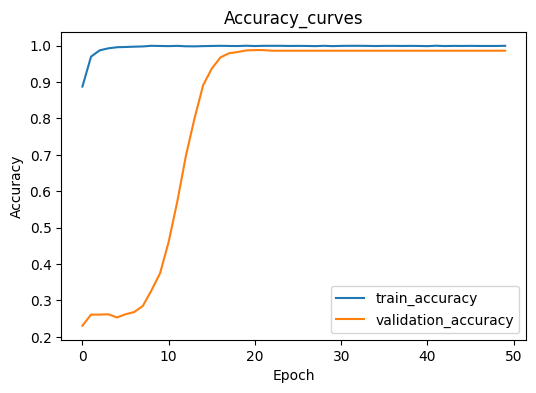

In [ ]:
# Plot training-accuracy & validation-accuracy.
plt.figure(figsize=(6,4))
plt.style.library['seaborn-darkgrid']
plt.title('Accuracy_curves')
plt.plot(history.history['accuracy'], linestyle='solid')
plt.plot(history.history['val_accuracy'], linestyle='solid')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

<ipython-input-23-3445d14e76c2>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-darkgrid']


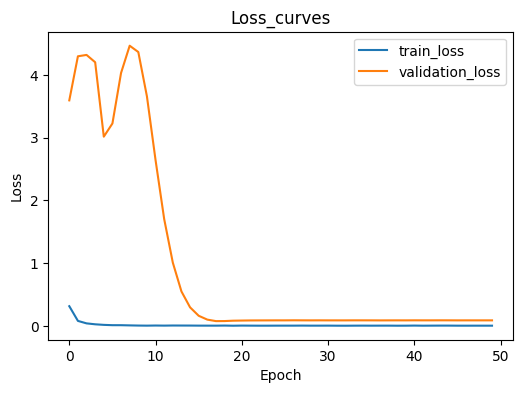

In [ ]:
# Plot training-accuracy & validation-accuracy.
plt.figure(figsize=(6,4))
plt.style.library['seaborn-darkgrid']
plt.title('Loss_curves')
plt.plot(history.history['loss'], linestyle='solid')
plt.plot(history.history['val_loss'], linestyle='solid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

## Validation on Test set

In [ ]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 3s 51ms/step - loss: 1.5991 - accuracy: 0.9886


In [ ]:
import seaborn as sns
predicted_classes = np.argmax(model_1.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

41/41 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.97      0.97       306
    no_tumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    img = cv2.resize(img, (200, 200))  # Resize to a consistent size
    img = img / 255.0  # Normalize pixel values (assuming a model trained on [0, 1])

    return img

In [ ]:
image_path = "path_to_image_folder"

target_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
def predict_class(model, image_path, show = True):
  for filename in os.listdir(image_path):
    if filename.endswith('.jpg'):
        curr_image = os.path.join(image_path, filename)
        preprocessed_image = preprocess_image(curr_image)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
        prediction = model_1.predict(preprocessed_image)

        if show:
            plt.figure(figsize=(3, 2))
            plt.imshow(preprocessed_image[0])
            plt.axis('off')
            plt.title(f'Prediction: {target_labels[np.argmax(prediction)]}')
            plt.show()


1/1 [==============================] - 0s 122ms/step


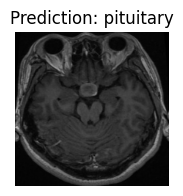

1/1 [==============================] - 0s 119ms/step


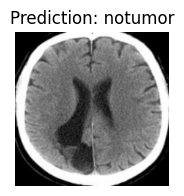

1/1 [==============================] - 0s 114ms/step


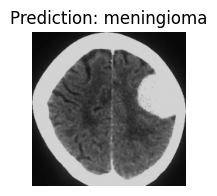

1/1 [==============================] - 0s 124ms/step


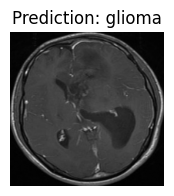

In [ ]:
predict_class(model_1, image_path)
